###1. Use Resnet18 to train on CIFAR-10	

###2. Experiment on the following and compare the result with baseline
* Input image normalization
* Data augmentation
* Different base learning rate and update strategy
* Different batch size

###3. Print test loss and test acc

###4. Plot train-loss, val-loss, train-acc, val-acc

###5. Accuracy(>90%拿滿，>80%才有基本分)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

In [15]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [16]:
# 檢查是否可用gpu
print(torch.cuda.is_available())

True


In [17]:
# setting parameter
EPOCH = 0     
BATCH_SIZE = 128    
lr = 0.05        
device = torch.device("cuda")

In [18]:
# 計算normalization需要的mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = iter(dataloader).next()[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)

print(train_mean, train_std)

Files already downloaded and verified
[0.4920185  0.48242217 0.4461911 ] [0.24710633 0.2435445  0.26161584]


In [19]:
# 計算Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [20]:
normalize = transforms.Normalize(mean = (0.4901,0.4809,0.4445), std = (0.2460,0.2425,0.2607))

# data augmentation & normalization
transform_train = transforms.Compose([
    # data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    normalize
   
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    normalize,
])

In [21]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset長怎麼樣 
#print(trainset)
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   #生成batch 
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
train length:  45000
val length:  5000
test length:  10000


In [22]:
# learning rate shedule
def adjust_learning_rate(optim, epoch):
    # define your lr scheduler
    lr_list = [0.05,0.025,0.01,0.005,0.001]
    if epoch == 10:
        lr_t = 0.025
    elif epoch == 20:
        lr_t = 0.01
    elif epoch == 30:
        lr_t = 0.005
    elif epoch == 35:
        lr_t = 0.001
    else:
        lr_t = optim.param_groups[0]['lr']

    for param_group in optim.param_groups:    # change the lr to what you define
        param_group['lr'] = lr_t

In [23]:
#是否pretrain
#net = models.resnet18(pretrained = False).to(device)
net = models.resnet18(pretrained = False)
net.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.maxpool = torch.nn.Identity()
net.fc = nn.Linear(512,10)
net = net.to(device)
print(net)
if device == 'cuda':
  net = torch.nn.DataParallel(net)

# 定義損失函數和優化方式
criterion = nn.CrossEntropyLoss()  #loss function 
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)   # momentum-SGD，採用L2正則化（權重衰減）
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
if __name__ == "__main__":
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    for epoch in range(40):
        # train
        net.train()
        sum1_loss, sum2_loss = 0.0, 0.0
        correct = 0.0
        total = 0.0
        print('\nEpoch: %d' % (epoch + 1))
        for i, traindata in enumerate(trainloader, 0):
            # prepare data
            inputs, train_labels = traindata
            inputs, train_labels = inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()

            # forward + backward
            train_outputs = net(inputs)
            trainloss = criterion(train_outputs, train_labels)
            trainloss.backward()
            optimizer.step()

            # 每訓練1個batch的loss和acc
            sum1_loss += trainloss.item()
            _, predicted = torch.max(train_outputs.data, 1)     # 取得分數最高的那個類 (outputs.data的index)
            total += train_labels.size(0)
            correct += predicted.eq(train_labels.data).cpu().sum()

        # learning rate schedule
        #writer.add_scalar("lr", optimizer.param_groups[0]['lr'], epoch)
        adjust_learning_rate(optimizer, epoch)
        print("learning rate: ",  optimizer.param_groups[0]['lr'])
        
        loss1 = sum1_loss / (i + 1)
        acc1 = correct / total
        print("Train loss: %.3f | Train acc: %.3f" % (loss1, acc1))
        train_loss.append(loss1)
        train_acc.append(acc1.item())

        # 用val驗證
        with torch.no_grad():
            correct = 0
            total = 0
            for j, valdata in enumerate(valloader, 0):
                net.eval()
                images, val_labels = valdata
                images, val_labels = images.to(device), val_labels.to(device)
                val_outputs = net(images)
                valloss = criterion(val_outputs, val_labels)
                        
                sum2_loss += valloss.item()
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum()
                    
            loss2 = sum2_loss / (j + 1)
            acc2 = correct / total
            print("Val loss: %.3f | Val acc: %.3f" % (loss2, acc2))
            val_loss.append(loss2)
            val_acc.append(acc2.item())

    # 用test測試
    with torch.no_grad():
        correct = 0
        total = 0
        sum3_loss = 0.0
        for k, testdata in enumerate(testloader, 0):
            net.eval()
            imgs, test_labels = testdata
            imgs, test_labels = imgs.to(device), test_labels.to(device)
            test_outputs = net(imgs)
            testloss = criterion(test_outputs, test_labels)
                        
            sum3_loss += testloss.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum()
                    
        loss3 = sum3_loss / (k + 1)
        acc3 = correct / total
        print("Test loss: %.3f | Test acc: %.3f" % (loss3, acc3))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


learning rate:  0.05
Train loss: 1.693 | Train acc: 0.385
Val loss: 1.531 | Val acc: 0.439

Epoch: 2
learning rate:  0.05
Train loss: 1.166 | Train acc: 0.580
Val loss: 1.077 | Val acc: 0.617

Epoch: 3
learning rate:  0.05
Train loss: 0.894 | Train acc: 0.681
Val loss: 1.050 | Val acc: 0.641

Epoch: 4
learning rate:  0.05
Train loss: 0.738 | Train acc: 0.745
Val loss: 0.789 | Val acc: 0.730

Epoch: 5
learning rate:  0.05
Train loss: 0.634 | Train acc: 0.777
Val loss: 0.738 | Val acc: 0.737

Epoch: 6
learning rate:  0.05
Train loss: 0.558 | Train acc: 0.806
Val loss: 0.682 | Val acc: 0.762

Epoch: 7
learning rate:  0.05
Train loss: 0.514 | Train acc: 0.822
Val loss: 0.576 | Val acc: 0.802

Epoch: 8
learning rate:  0.05
Train loss: 0.463 | Train acc: 0.842
Val loss: 0.496 | Val acc: 0.824

Epoch: 9
learning rate:  0.05
Train loss: 0.429 | Train acc: 0.851
Val loss: 0.713 | Val acc: 0.767

Epoch: 10
learning rate:  0.05
Train loss: 0.404 | Train acc: 0.860
Val loss: 0.493 | Val acc: 0.837

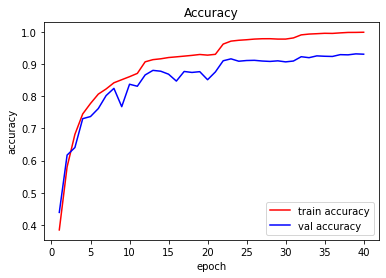

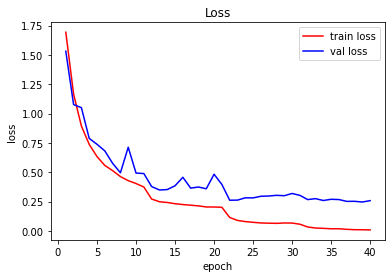

In [25]:
import matplotlib.pyplot as plt
# plot accuracy curve
EPOCH = 40
plt.figure(0)
plt.plot(range(1,EPOCH+1,1), np.array(train_acc), 'r-', label= "train accuracy") 
plt.plot(range(1,EPOCH+1,1), np.array(val_acc), 'b-', label= "val accuracy")
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# plot loss curve
plt.figure(1)
plt.plot(range(1,EPOCH+1,1), np.array(train_loss), 'r-', label= "train loss") 
plt.plot(range(1,EPOCH+1,1), np.array(val_loss), 'b-', label= "val loss")
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()